# Lab 11: Differential Privacy
Welcome to the 11th (and final) DS102 lab!!

The goal of this lab is to gain a better understanding of differential privacy. We will observe what happens after the Laplace mechanism is applied to an estimator, which is discussed in Tuesday's (today's) lecture. This demonstration is related to an experiment done by [Duchi et al. 2017](https://arxiv.org/abs/1604.02390).

The code you need to write is commented out with a message "TODO: fill ...". There is additional documentation for each part as you go along.

## Collaboration Policy {-}
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission {-}
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Sunday, May 02, 2020 at 11:59 PM. PT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
%matplotlib inline

# National Estimates of Drug-Related Emergency Department Visits (NEDREDV) {-}

In this lab, we will analyze drug use data from the [National Estimates
of Drug-Related Emergency Department Visits (NEDREDV)](https://www.samhsa.gov/data/report/national-estimates-drug-related-emergency-department-visits-2004-2011-all-visits).

The NEDREDV dataset tracks the number of hospital emergency department visits related to drug usage in a given year. We look at data from 2004 and consider the number of hospital admissions for several common drugs:  *Alcohol, Cocaine, Heroin, Marijuana, Stimulants, Amphetamines, Methamphetamine, MDMA, LSD, PCP, Antidepressants, Antipsychotics, Miscellaneous hallucinogens, Inhalants, lithium, Opiates,
Opiates unspecified, Narcotic analgesics, Buprenorphine, Codeine, Fentanyl, Hydrocodone, Methadone, Morphine,
Oxycodone, Ibuprofen, and Muscle relaxants.*

The NEDREDV dataset that we import includes the $d = 27$ drugs, and the observed probability that a person admitted to the hospital for drug abuse in 2004 used drug $j$. Note that a person admitted to the hospital could have used multiple drugs simultaneously, so the probabilities do not sum to 1.

In [2]:
nedredv_df = pd.read_csv('nedredv_probs.csv')

In [3]:
nedredv_df

,Substance,Probability
0,Alcohol,0.530527
1,Cocaine,0.325744
2,Heroin,0.109529
3,Marijuana,0.218641
4,Stimulants,0.101317
5,Amphetamines,0.027766
6,Methamphetamine,0.077830
7,MDMA,0.007762
8,LSD,0.001503
9,PCP,0.027706


## Simulating a privacy-sensitive dataset {-}

The NEDREDV dataset itself does not contain the actual drug usage of each individual person admitted to the hospital: it only contains rates of the total number of people admitted to the hospital for using each drug. For the purposes of this lab, we will instead *simulate* a  privacy-sensitive dataset that contains the drug usage of the individuals admitted to the hospital. We will generate a dataset $X = \{X_1, . . . , X_N \}$ where each $X_i \in \{0, 1\}^d$ represents an individual admitted to the hospital, and $X_{i,j}$ is 1 if the individual abuses drug $j$ and 0 otherwise. Since drug use is a sensitive topic, it would certainly be a privacy problem if such a dataset $X$ containing the drug usage of individuals admitted to the hospital were made public (and it would likely violate [HIPAA](https://www.hhs.gov/hipaa/index.html)). 

To generate this privacy-sensitive dataset, let $p_j$ be the observed probability that a person admitted to the hospital used drug $j$ according to the NEDREDV data from 2004. We draw $$X_{i,j} \sim Bernoulli(p_j)$$ independently for all $i = 1,...,N$ and for all $j = 1,...,d$. This results in a set of hypothetical individuals $X_1,...,X_N$ where the marginal counts $\frac{1}{N}\sum_{i=1}^N X_{i,j}$ yield approximately the correct drug use frequencies to match the NEDREDV data. 

In [4]:
def simulate_private_data(nedredv_df, N=30000, random_seed = None):
    """Simulates the privacy-sensitive dataset with individual drug usage.
    
    Inputs: 
        nedredv_df : dataframe containing the drug and the probability that an admittee used the drug.
        N : number of individuals to generate.
        random_seed : int, random seed for experimental reproducibility
      
    Returns:
        X_df : dataframe containing N rows where each row corresponds to an admitted individual, 
            and a 1 in a column corresponding to a given drug means that the individual used that drug.
    """
    X = {}
    for index, row in nedredv_df.iterrows(): 
        drug_name = row['Substance']
        observed_probability = row['Probability']
        X_row = bernoulli.rvs(observed_probability, size=N, random_state = np.random.RandomState(seed=random_seed))
        X[drug_name] = X_row
        X_df = pd.DataFrame(X)
    return X_df

In [5]:
X_df = simulate_private_data(nedredv_df, random_seed = 22)
X_df.head()

,Alcohol,Cocaine,Heroin,Marijuana,Stimulants,Amphetamines,Methamphetamine,MDMA,LSD,PCP,...,Narcotic_analgesics,Buprenorphine,Codeine,Fentanyl,Hydrocodone,Methadone,Morphine,Oxycodone,Ibuprofen,Muscle_relaxants
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Notice that each row of the dataframe X_df corresponds to an individual, $X_i$, and a $1$ in a column corresponding to a given drug means that the individual used that drug. An individual admitted to the hospital could have used multiple drugs simultaneously.

# Goal: Mean estimation with differential privacy

From now on, we will treat the dataset that we just generated as ground truth. We will seek to analyze statistics about this data without hurting the privacy of the individuals in the dataset that we just generated.

Specifically, the statistic we want to estimate is the mean of the population:
$\theta = E[X]$. But, the catch is that we want to estimate this mean in a **differentially private** way. 

## The true mean
Based on the way the data was generated, we know that the true mean of the distribution that the samples were drawn from is the original probabilities from the NEDREDV dataset. Our goal will be to estimate this true mean from the dataset that we generated in a differentially private way.

In [6]:
TRUE_MEAN = nedredv_df['Probability'].to_numpy()
print(nedredv_df)

                      Substance  Probability
0                       Alcohol     0.530527
1                       Cocaine     0.325744
2                        Heroin     0.109529
3                     Marijuana     0.218641
4                    Stimulants     0.101317
5                  Amphetamines     0.027766
6               Methamphetamine     0.077830
7                          MDMA     0.007762
8                           LSD     0.001503
9                           PCP     0.027706
10              Antidepressants     0.094340
11               Antipsychotics     0.052264
12  Miscellaneous_hallucinogens     0.001879
13                    Inhalants     0.009668
14                      lithium     0.007860
15                      Opiates     0.174578
16          Opiates_unspecified     0.032600
17          Narcotic_analgesics     0.147420
18                Buprenorphine     0.001014
19                      Codeine     0.009444
20                     Fentanyl     0.007097
21        

## Differential privacy {-}

The idea behind differential privacy is that any given individual should be willing to participate in the statistical analysis
because their participation in the study does not change the outcome of the study by very much;
their personal information cannot be recovered from the results of either removing or adding them to the study. This applies to the individuals in the dataset we generated: removing any individual from the data should not change our mean estimate that much. Otherwise, it may be possible to recover the drug usage of an individual based on a mean estimate that includes the individual and another mean estimate that doesn't include the individual.

For two datasets $X$ and $X'$ which differ in only one entry (e.g., differing in one individual), an $\epsilon$-**differentially private algorithm** $\mathcal{A}$ satisfies:

$$\mathbb{P}\{\mathcal{A}(X) = a\} \leq e^{\epsilon}\mathbb{P}\{\mathcal{A}(X')= a\},$$

for all possible output values $a$ of the algorithm $\mathcal{A}$. In words, the probability of seeing any given output of a differentially private algorithm doesn't change much by replacing any one entry in the dataset.

We will explore three algorithms for estimating the mean in this lab:

1. **Algorithm 1: Non-private:** we will simply take the sample mean of the given data $X$, $$\hat{\theta} = \mathcal{A}(X) = f(X) = \frac{1}{N}\sum_{i=1}^N X_i.$$ This is not differentially private: we can recover the drug usage of an individual if we estimate the mean before and after removing the individual.

2. **Algorithm 2: Laplace mechanism:** To introduce differential privacy, we can apply the Laplace mechanism that we went over in Discussion 13. Given the non-private estimator $f(X)$, we can add noise $\xi_{\epsilon}$: $$\hat{\theta} = \mathcal{A}(X) = f(X) + \xi_{\epsilon} = \left(\frac{1}{N}\sum_{i=1}^N X_i\right) + \xi_{\epsilon}.$$ We will go over this algorithm in more detail later in the lab.

3. **Algorithm 3: Locally differentially private Laplace mechanism:** another way to introduce differential privacy is to make the data locally differentially private. In the above Algorithm 2, we added a single noise parameter $\xi_{\epsilon}$ to the non-private estimate $f(X)$. Rather than adding noise to the aggregated $f(X)$, we could also add noise to each sensitive bit individually, $X_i$. $$\hat{\theta} = \mathcal{A}(X) = f(X + \xi_{\epsilon}) = \frac{1}{N}\sum_{i=1}^N (X_i + \xi_{\epsilon}^i ).$$ We will also go over this algorithm in more detail later in the lab.

Both Algorithm 2 and Algorithm 3 result in estimators $\hat{\theta}$ that are $\epsilon$-differentially private. The difference between Algorithm 2 and Algorithm 3 is that Algorithm 3 introduces more noise overall by introducing noise $\xi_{\epsilon}^i$ into each row. However, the local approach of Algorithm 3 ensures privacy even if we don't trust the person or program calculating $f(X)$ in Algorithm 2.

# Question 1.  Algorithm 1: Non-private {-}

We will now implement the three algorithms, and compare how well they accomplish the task of mean estimation. We'll start with Algorithm 1.

For Algorithm 1, the obvious algorithm for mean estimation is to simply take the mean of the samples, $X_i$: 

$$\hat{\theta} = \mathcal{A}(X) = f(X) = \frac{1}{N}\sum_{i=1}^N X_i$$

However, this is clearly not differentially private: we can recover the drug usage of an individual if we estimate the mean before and after removing the individual.

## 1.a. Implement Algorithm 1
First, we need to implement the calculation of $\hat{\theta}$ using Algorithm 1.

In [7]:
# TODO: estimate the mean of the data using the non-private Algorithm 1.
def alg_1_estimate(input_X_df):
    """Estimates the mean of the data using the non-private Algorithm 1.
    
    Inputs: 
        input_X_df : dataframe where each row corresponds to an individual, 
            and a 1 in a column corresponding to a given drug means that
            the individual used that drug. 
        
    Outputs:
        mean_estimate : d-dimensional numpy array containing mean of all of the rows in X_df.
    
    """
    mean_estimate = input_X_df.mean().to_numpy() # mean
    return mean_estimate

In [8]:
# Validation tests (do not modify)
test_input = simulate_private_data(nedredv_df, N=100, random_seed = 0)
test_output = alg_1_estimate(test_input)
true_output= np.array([0.54, 0.26, 0.1 , 0.17, 0.09, 0.04, 0.09, 0.  , 0.  , 0.04, 0.09,
                       0.05, 0.  , 0.  , 0.  , 0.14, 0.04, 0.11, 0.  , 0.  , 0.  , 0.05,
                       0.04, 0.  , 0.05, 0.04, 0.04])
assert np.max(abs(test_output - true_output)) < 0.01
print("Test passed!")

Test passed!


In [9]:
# Print the estimates according to Algoritm 1
nedredv_df['Algo_1_estimates'] = alg_1_estimate(X_df)
nedredv_df

,Substance,Probability,Algo_1_estimates
0,Alcohol,0.530527,0.527567
1,Cocaine,0.325744,0.328867
2,Heroin,0.109529,0.109433
3,Marijuana,0.218641,0.220433
4,Stimulants,0.101317,0.100267
5,Amphetamines,0.027766,0.027333
6,Methamphetamine,0.077830,0.077867
7,MDMA,0.007762,0.007567
8,LSD,0.001503,0.001300
9,PCP,0.027706,0.027233


## 1.b. Compute the max error of the mean estimate {-}
To judge how good our mean estimate was, we will use the max error, or the [infinity-norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Maximum_norm_(special_case_of:_infinity_norm,_uniform_norm,_or_supremum_norm)): 
$$||\hat{\theta} - \theta||_\infty = \max_i{|\hat{\theta}_i - \theta_i}|$$

This just finds the max difference between any two coordinates of the true mean $\theta$ and the estimated mean $\hat{\theta}$.

Now, we will implement the max error function, and calculate the max error of Algorithm 1.

In [10]:
# TODO: compute the max error between the estimated mean and the true mean.
def max_error(estimated_mean, true_mean):
    """Computes the maximum error between the estimated mean and the true mean.
    
    Inputs:
        estimated_mean: numpy array of length d containing the estimated mean.
        true_mean: numpy array of length d containing the true mean.
    
    Outpus:
        max_error: the/'' max error between the estimated_mean and true_mean. 
            This should be the max of the absolute value of all of the coordinates
            of estimated_mean - true_mean.
    """
    # max_err = # TODO: fill in
    return max(np.abs(estimated_mean - true_mean))

In [11]:
# Validation tests: Do not modify
test_input=[np.array([0.34, 0.66, 0.41]),np.array([0.36, 0.58, 0.45])]
assert np.abs(max_error(*test_input)-0.08)<0.0001
print("Test passed!")

Test passed!


In [12]:
print("Max error of Algorithm 1: {:.6f}".format(max_error(alg_1_estimate(X_df), TRUE_MEAN)))

Max error of Algorithm 1: 0.003123


# Question 2. Algorithm 2: Laplace mechanism {-}
To introduce differential privacy, we can apply the Laplace mechanism that we will go over in Discussion 13. Given the non-private estimator $f(X)$, we can add noise $\xi_{\epsilon}$:
$$\hat{\theta} = \mathcal{A}(X) = f(X) + \xi_{\epsilon} = \left(\frac{1}{N}\sum_{i=1}^N X_i\right) + \xi_{\epsilon}$$


$\xi_{\epsilon} \in \mathbb{R}^d$ has independent coordinates, each distributed according to the zero-mean Laplace distribution with scale parameter $\frac{\Delta_f}{\epsilon}$, denoted $\text{Lap}(0,\frac{\Delta_f}{\epsilon})$. 

$\Delta_f$ is the sensitivity of the function $f$, defined as 
$$\Delta_f = \max_{\text{neighboring } X,X'} ||f(X) - f(X')||_1,$$
where $||.||_1$ is the [1-norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm). We need to use the 1-norm here because $f(X) \in \mathbb{R}^d$.

Solving for this,

$$\begin{align*}
\Delta_f &= \max_{\text{neighboring } X,X'} ||f(X) - f(X')||_1 \\
&= \max_{\text{neighboring } X,X'} \bigg|\bigg|\frac{1}{N}\sum_{i=1}^N X_i - \frac{1}{N}\sum_{i=1}^N X_i'\bigg|\bigg|_1 \\
&= \frac{d}{N}
\end{align*}
$$

In Discussion 13, we showed that the above algorithm $\mathcal{A}(X)$ is $\epsilon$-differentially private. 

## Implement Algorithm 2 {-}

Calculate $\hat{\theta}$ using Algorithm 2 above. 

Plugging in the calculation for $\Delta_f$ above, we have $\xi_{\epsilon} \in \mathbb{R}^d$ has independent coordinates, each distributed according to the zero-mean Laplace distribution with scale parameter $\frac{d}{N\epsilon}$, denoted $\text{Lap}(0,\frac{d}{N\epsilon})$.

In [13]:
# TODO: estimate the mean of the data using Algorithm 2.
def alg_2_estimate(input_X_df, epsilon=0.5, random_seed = None):
    """Estimates the mean of the data using Algorithm 2.
    
    Inputs: 
        input_X_df: dataframe where each row corresponds to an individual, 
            and a 1 in a column corresponding to a given drug means that
            the individual used that drug. 
        epsilon: differential privacy parameter.
        random_seed: int, random seed for experimental reproducibility
        
    Outputs:
        mean_estimate: d-dimensional numpy array containing the mean estimate.
    
    """
    random_state = np.random.RandomState(seed=random_seed)
    d = len(input_X_df.columns)
    N = len(input_X_df)
    laplace_scale = d / (N * epsilon) # TODO
    
    xi = random_state.laplace(0, laplace_scale, size=d)
    mean_estimate = input_X_df.mean().to_numpy() + xi
    return mean_estimate

In [14]:
# Validation tests (do not modify)
test_input = simulate_private_data(nedredv_df, N=1000, random_seed = 1)
test_output = alg_2_estimate(test_input, random_seed = 6)
true_output= np.array([ 0.61118555,  0.30388517,  0.16553917,  0.08185385,  0.01907432,
                        0.04238588,  0.07632029, -0.00456863, -0.02156009,  0.04617881,
                        0.08586842,  0.08546348,  0.00198393,  0.01626853,  0.02354852,
                        0.38347409,  0.08912664,  0.1377036 ,  0.07541032,  0.06230894,
                       -0.11471126,  0.08304802,  0.08106895,  0.04457083,  0.07825384,
                        0.0356127 , -0.04093591])
assert np.max(abs(test_output - true_output)) < 0.01
print("Test passed!")

Test passed!


In [15]:
# Print the estimates according to Algoritm 2
alg_2_estimates = alg_2_estimate(X_df, random_seed = 17)
nedredv_df['Algo_2_estimates'] = alg_2_estimates
nedredv_df

,Substance,Probability,Algo_1_estimates,Algo_2_estimates
0,Alcohol,0.530527,0.527567,0.526615
1,Cocaine,0.325744,0.328867,0.328980
2,Heroin,0.109529,0.109433,0.107706
3,Marijuana,0.218641,0.220433,0.216840
4,Stimulants,0.101317,0.100267,0.101803
5,Amphetamines,0.027766,0.027333,0.028008
6,Methamphetamine,0.077830,0.077867,0.078446
7,MDMA,0.007762,0.007567,0.007862
8,LSD,0.001503,0.001300,-0.003289
9,PCP,0.027706,0.027233,0.026631


In [16]:
# Print the max error of Algorithm 2
print("Max error of Algorithm 2: {:.6f}".format(max_error(alg_2_estimates, TRUE_MEAN)))

Max error of Algorithm 2: 0.004791


# Question 3. Algorithm 3: Locally differentially private Laplace mechanism {-}
Finally, another way to introduce differential privacy is to make the data locally differentially private. In the above Algorithm 2, we added a single noise parameter $\xi_{\epsilon}$ to the non-private estimate $f(X)$. As we will discuss in lecture, rather
than adding noise to the aggregated $f(X)$, we could also add noise to each sensitive bit individually, $X_i$. 

$$\hat{\theta} = \mathcal{A}(X) = f(X + \xi_{\epsilon}) = \frac{1}{N}\sum_{i=1}^N (X_i + \xi_{\epsilon}^i )$$

Here, $\xi_{\epsilon} \in \mathbb{R}^{N \times d}$ is making each row in the data differentially private before it even reaches the function $f(X)$. For each individual row $X_i$, $\xi_{\epsilon}^i \in \mathbb{R}^d$ has independent coordinates, each distributed according to the zero-mean Laplace distribution with parameter $\frac{\Delta_{X_i}}{\epsilon}$, denoted $\text{Lap}(0,\frac{\Delta_{X_i}}{\epsilon})$. 

$\Delta_{X_i}$ is the sensitivity of changing a single row $X_i$:
$$\Delta_{X_i} = \max_{X_i \neq X_i'} || X_i - X_i')||_1 = d$$

It can be similarly shown that adding noise $\xi_{\epsilon}^i$ to each row $X_i$ makes each row itself differentially private, and by the Composition Guarantees for Differential Privacy, this locally differentially private algorithm $\mathcal{A}(X)$ is also $\epsilon$-differentially private. 

The difference between Algorithm 2 and Algorithm 3 is that Algorithm 3 introduces more noise overall by introducing noise $\xi_{\epsilon}^i$ into each row. However, the local approach of Algorithm 3 ensures privacy even if we don't trust the person or program calculating $f(X)$ in Algorithm 2.


## 3.a. Implement Algorithm 3 {-}

Calculate $\hat{\theta}$ using Algorithm 3 above. 

Plugging in the calculation for $\Delta_{X_i}$ above, we have $\xi_{\epsilon}^i \in \mathbb{R}^d$ has independent coordinates, each distributed according to the zero-mean Laplace distribution with parameter $\frac{d}{\epsilon}$, denoted $\text{Lap}(0,\frac{d}{\epsilon})$.

In [17]:
# TODO: estimate the mean of the data using Algorithm 3.
def alg_3_estimate(input_X_df, epsilon=0.5, random_seed = None):
    """Estimates the mean of the data using Algorithm 3.
    
    Inputs: 
        input_X_df: dataframe where each row corresponds to an individual, 
            and a 1 in a column corresponding to a given drug means that
            the individual used that drug. 
        epsilon: differential privacy parameter.
        random_seed: int, random seed for experimental reproducibility
        
    Outputs:
        mean_estimate: d-dimensional numpy array containing the mean estimate.   
    """
    random_state = np.random.RandomState(random_seed)
    d = len(input_X_df.columns)
    N = len(input_X_df)
    laplace_scale = d / epsilon # TODO
    
    # Adds the xi_i noise to each row X_i. 
    X = input_X_df.to_numpy(dtype=float)
    for i in range(len(X)):
        xi_i = random_state.laplace(0, laplace_scale, size=d)
        X[i] += xi_i
    
    mean_estimate =  np.mean(X, axis=0)
    return mean_estimate

In [18]:
# Validation tests (do not modify)
test_input = simulate_private_data(nedredv_df, N=10000, random_seed = 8)
test_output = alg_3_estimate(test_input, random_seed = 2)
true_output= np.array([-0.40967514,  0.07351822, -0.4317238 ,  1.00062335, -0.5200155 ,
                       -0.89679615, -0.65737125, -0.29722826,  0.84077436,  0.40867117,
                       -1.00796038, -0.43696672,  0.01821487, -1.80613563, -0.90836173,
                       -0.17835337,  0.72904829, -0.72107227,  0.15482221, -0.55084658,
                       -0.31396992, -0.3488769 ,  0.77788347,  0.45583122,  0.05131975,
                        0.77705583,  0.56286043])
assert np.max(abs(test_output - true_output)) < 0.01
print("Test passed!")

Test passed!


In [19]:
# Print the estimates according to Algoritm 3
alg_3_estimates = alg_3_estimate(X_df, random_seed = 11)
nedredv_df['Algo_3_estimates'] = alg_3_estimates
nedredv_df

,Substance,Probability,Algo_1_estimates,Algo_2_estimates,Algo_3_estimates
0,Alcohol,0.530527,0.527567,0.526615,0.563574
1,Cocaine,0.325744,0.328867,0.328980,0.388357
2,Heroin,0.109529,0.109433,0.107706,-0.866334
3,Marijuana,0.218641,0.220433,0.216840,0.131663
4,Stimulants,0.101317,0.100267,0.101803,0.198052
5,Amphetamines,0.027766,0.027333,0.028008,-0.269192
6,Methamphetamine,0.077830,0.077867,0.078446,-0.282818
7,MDMA,0.007762,0.007567,0.007862,-0.046022
8,LSD,0.001503,0.001300,-0.003289,-0.279306
9,PCP,0.027706,0.027233,0.026631,0.558815


In [20]:
# Print the max error of Algorithm 3
print("Max error of Algorithm 3: {:.6f}".format(max_error(alg_3_estimates, TRUE_MEAN)))

Max error of Algorithm 3: 0.975862


### 3.b. Question: Rank all three algorithms in order of how close the mean estimate was to the true mean. For the algorithm that had the worst estimate, why do you think it had the worst estimate?  {-}

Answer: Algorithm 1 performed better than Algorithm 2 which performed better than Algorithm 3 by a lot. Algorithm 3 had the worst mean estimate because it added the most noise: it added noise to all data points $X_i$.

### 3.c. Question: Both Algorithm 2 and Algorithm 3 are $\epsilon$-differentially private, but have different performances for mean estimation. Can you come up with a hypothetical practical scenario where you might want to use Algorithm 3 instead of Algorithm 2?

Answer: Algorithm 2 requires computing $f(X)$ first, then adding noise. You might want to use Algorithm 3 if you don't trust the code computing $f(X)$. 

# Question 4. Break the privacy of Algorithm 1 {-}

We said that Algorithm 1 is not private. In this question you will try to 'break' it in order to obtain private patient information. Denote by $S$ the original dataset, and by $S'$ a 'neighboring' dataset. The dataset $S$ and $S'$ differ only for one patients, whose data has been modified. Here by modifications we mean flipping some of the respective 0/1 from the row corresponding to that patient.

You are given only $N=30000$, $f(S)$ and $f(S')$ (you don't have access to either $S$ or $S$: Attempt to obtain private information about the patient whose data has been modified.

`Hint:` You should be able to infer that this patient was admitted to hospital having consumed cocaine and amphetamines, but not alcohol

In [22]:
N = 30000

f_S = np.array([0.52756667, 0.32886667, 0.10943333, 0.22043333, 0.10026667,
                0.02733333, 0.07786667, 0.00756667, 0.0013    , 0.02723333,
                0.0933    , 0.05243333, 0.00166667, 0.00933333, 0.0077    ,
                0.17586667, 0.03213333, 0.14803333, 0.00066667, 0.00913333,
                0.00693333, 0.05323333, 0.0286    , 0.0105    , 0.05163333,
                0.02736667, 0.03193333])

f_S_prime = np.array([0.52753333, 0.3289    , 0.10943333, 0.22043333, 0.10026667,
                      0.02736667, 0.07786667, 0.00756667, 0.0013    , 0.02723333,
                      0.0933    , 0.05243333, 0.00166667, 0.00933333, 0.0077    ,
                      0.17586667, 0.03213333, 0.14803333, 0.00066667, 0.00913333,
                      0.00693333, 0.05323333, 0.0286    , 0.0105    , 0.05163333,
                      0.02736667, 0.03193333])

In [23]:
patient_array = (N*f_S - N * f_S_prime)/2
patient_array

array([ 0.5001 , -0.49995,  0.     ,  0.     ,  0.     , -0.5001 ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ])

In [24]:
patient_df = pd.DataFrame({'Substance': nedredv_df['Substance'], 'Prob': patient_array})
patient_df

,Substance,Prob
0,Alcohol,0.50010
1,Cocaine,-0.49995
2,Heroin,0.00000
3,Marijuana,0.00000
4,Stimulants,0.00000
5,Amphetamines,-0.50010
6,Methamphetamine,0.00000
7,MDMA,0.00000
8,LSD,0.00000
9,PCP,0.00000


Probablity of patient having consumed alcohol is positive, whereas the probabilities of the patient consuming cocaine and amphetamines are below 0. Therefore, we can infer that this patient was admitted to hospital having consumed alcohol but not cocaine and amphetamines. (All other probablities are 0.)

Yay, you've made it to the end of ALL THE LABS!


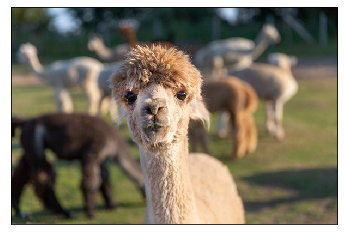

In [21]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('cute_alpaca.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of ALL THE LABS!")
plt.show()